Installing Dependencies

In [1]:
!pip install torch==1.7.1
!pip install torchvision==0.8.2
# !pip install os
# !pip install opencv-python
# !pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Restart Runtime after changing torchvision version

Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/Colab_Notebooks/SSD/SSD-pytorch

/content/drive/MyDrive/Colab_Notebooks/SSD/SSD-pytorch


Importing Libraries

In [4]:
import numpy as np
import cv2
from PIL import Image
import os
import itertools
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import shutil
import torch
import torch.nn as nn
import torchvision
from src.transform import SSDTransformer
from src.utils import generate_dboxes, Encoder, colors, coco_classes
from torchvision.datasets import CocoDetection
from torch.utils.data.dataloader import default_collate
from torchvision.models.resnet import resnet50
from torchvision.models.mobilenet import mobilenet_v2, InvertedResidual
from pycocotools.cocoeval import COCOeval
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from src.model import SSD, SSDLite, ResNet, MobileNetV2
from src.loss import Loss
import torch.nn.functional as F
from torchvision.ops.boxes import box_iou, box_convert


Defining Variables

In [5]:

cls_threshold=0.3
nms_threshold=0.5
epochs=65
batch_size=32
multistep=[43,54]
lr=2.6e-3
momentum =0.9
local_rank=0
num_workers=4
weight_decay= 0.0005
model="ssd"
parent_dir="/content/drive/MyDrive/Colab_Notebooks/SSD/SSD-pytorch"
pretrained_model_path=parent_dir +"/checkpoints"
ckpt = pretrained_model_path+"/SSD.pth"
dataset_path= "/content/drive/MyDrive/Colab_Notebooks/data"+"/coco"
save_folder=parent_dir+"/trained_models"
log_path=parent_dir+"/tensorboard"
dir_path = dataset_path+"/val2017"
#result_dir=parent_dir+"/Results"

Helper Functions

In [6]:

def train(model, train_loader, epoch, writer, criterion, optimizer, scheduler):
    model.train()
    num_iter_per_epoch = len(train_loader)
    progress_bar = tqdm(train_loader)
    scheduler.step()
    for i, (img, _, _, gloc, glabel) in enumerate(progress_bar):
        if torch.cuda.is_available():
            img = img.cuda()
            gloc = gloc.cuda()
            glabel = glabel.cuda()

        ploc, plabel = model(img)
        ploc, plabel = ploc.float(), plabel.float()
        gloc = gloc.transpose(1, 2).contiguous()
        loss = criterion(ploc, plabel, gloc, glabel)

        progress_bar.set_description("Epoch: {}. Loss: {:.5f}".format(epoch + 1, loss.item()))

        writer.add_scalar("Train/Loss", loss.item(), epoch * num_iter_per_epoch + i)

        # if is_amp:
        #     with amp.scale_loss(loss, optimizer) as scale_loss:
        #         scale_loss.backward()
        # else:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


def evaluate(model, test_loader, epoch, writer, encoder, nms_threshold):
    model.eval()
    detections = []
    category_ids = test_loader.dataset.coco.getCatIds()
    for nbatch, (img, img_id, img_size, _, _) in enumerate(test_loader):
        print("Parsing batch: {}/{}".format(nbatch, len(test_loader)), end="\r")
        if torch.cuda.is_available():
            img = img.cuda()
        with torch.no_grad():
            # Get predictions
            ploc, plabel = model(img)
            ploc, plabel = ploc.float(), plabel.float()

            for idx in range(ploc.shape[0]):
                ploc_i = ploc[idx, :, :].unsqueeze(0)
                plabel_i = plabel[idx, :, :].unsqueeze(0)
                try:
                    result = encoder.decode_batch(ploc_i, plabel_i, nms_threshold, 200)[0]
                except:
                    print("No object detected in idx: {}".format(idx))
                    continue

                height, width = img_size[idx]
                loc, label, prob = [r.cpu().numpy() for r in result]
                for loc_, label_, prob_ in zip(loc, label, prob):
                    detections.append([img_id[idx], loc_[0] * width, loc_[1] * height, (loc_[2] - loc_[0]) * width,
                                       (loc_[3] - loc_[1]) * height, prob_,
                                       category_ids[label_ - 1]])

    detections = np.array(detections, dtype=np.float32)

    coco_eval = COCOeval(test_loader.dataset.coco, test_loader.dataset.coco.loadRes(detections), iouType="bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    writer.add_scalar("Test/mAP", coco_eval.stats[0], epoch)

Defining SSD Model with backbone

In [7]:
class Base(nn.Module):
    def __init__(self):
        super().__init__()

    def init_weights(self):
        layers = [*self.additional_blocks, *self.loc, *self.conf]
        for layer in layers:
            for param in layer.parameters():
                if param.dim() > 1:
                    nn.init.xavier_uniform_(param)

    def bbox_view(self, src, loc, conf):
        ret = []
        for s, l, c in zip(src, loc, conf):
            ret.append((l(s).view(s.size(0), 4, -1), c(s).view(s.size(0), self.num_classes, -1)))

        locs, confs = list(zip(*ret))
        locs, confs = torch.cat(locs, 2).contiguous(), torch.cat(confs, 2).contiguous()
        return locs, confs


class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = resnet50(pretrained=True)
        self.out_channels = [1024, 512, 512, 256, 256, 256]
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:7])

        conv4_block1 = self.feature_extractor[-1][0]
        conv4_block1.conv1.stride = (1, 1)
        conv4_block1.conv2.stride = (1, 1)
        conv4_block1.downsample[0].stride = (1, 1)

    def forward(self, x):
        x = self.feature_extractor(x)
        return x


class SSD(Base):
    def __init__(self, backbone=ResNet(), num_classes=81):
        super().__init__()

        self.feature_extractor = backbone
        self.num_classes = num_classes
        self._build_additional_features(self.feature_extractor.out_channels)
        self.num_defaults = [4, 6, 6, 6, 4, 4]
        self.loc = []
        self.conf = []

        for nd, oc in zip(self.num_defaults, self.feature_extractor.out_channels):
            self.loc.append(nn.Conv2d(oc, nd * 4, kernel_size=3, padding=1))
            self.conf.append(nn.Conv2d(oc, nd * self.num_classes, kernel_size=3, padding=1))

        self.loc = nn.ModuleList(self.loc)
        self.conf = nn.ModuleList(self.conf)
        self.init_weights()

    def _build_additional_features(self, input_size):
        self.additional_blocks = []
        for i, (input_size, output_size, channels) in enumerate(
                zip(input_size[:-1], input_size[1:], [256, 256, 128, 128, 128])):
            if i < 3:
                layer = nn.Sequential(
                    nn.Conv2d(input_size, channels, kernel_size=1, bias=False),
                    nn.BatchNorm2d(channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(channels, output_size, kernel_size=3, padding=1, stride=2, bias=False),
                    nn.BatchNorm2d(output_size),
                    nn.ReLU(inplace=True),
                )
            else:
                layer = nn.Sequential(
                    nn.Conv2d(input_size, channels, kernel_size=1, bias=False),
                    nn.BatchNorm2d(channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(channels, output_size, kernel_size=3, bias=False),
                    nn.BatchNorm2d(output_size),
                    nn.ReLU(inplace=True),
                )

            self.additional_blocks.append(layer)

        self.additional_blocks = nn.ModuleList(self.additional_blocks)


    def forward(self, x):
        x = self.feature_extractor(x)
        detection_feed = [x]
        for l in self.additional_blocks:
            x = l(x)
            detection_feed.append(x)
        locs, confs = self.bbox_view(detection_feed, self.loc, self.conf)
        return locs, confs


feature_maps = {}


class MobileNetV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = mobilenet_v2(pretrained=True).features
        self.feature_extractor[14].conv[0][2].register_forward_hook(self.get_activation())

    def get_activation(self):
        def hook(self, input, output):
            feature_maps[0] = output.detach()

        return hook

    def forward(self, x):
        x = self.feature_extractor(x)
        return feature_maps[0], x


def SeperableConv2d(in_channels, out_channels, kernel_size=3):
    padding = (kernel_size - 1) // 2
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size,
                  groups=in_channels, padding=padding),
        nn.BatchNorm2d(in_channels),
        nn.ReLU6(),
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
    )


def StackedSeperableConv2d(ls_channels, multiplier):
    out_channels = 6 * multiplier
    layers = [SeperableConv2d(in_channels=in_channels, out_channels=out_channels) for in_channels in ls_channels]
    layers.append(nn.Conv2d(in_channels=ls_channels[-1], out_channels=out_channels, kernel_size=1))
    return nn.ModuleList(layers)


Dowloading MSCOCO dataset , size=26GB

In [8]:
if os.path.exists(dataset_path) is False:
  print("Downloading Data")
  os.makedirs(dataset_path, exist_ok=True)
  !wget  http://images.cocodataset.org/zips/val2017.zip -O /content/drive/MyDrive/Colab_Notebooks/data/coco/val2017.zip
  #!wget  http://images.cocodataset.org/zips/train2017.zip -O /content/drive/MyDrive/Colab_Notebooks/data/coco/train2017.zip
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O /content/drive/MyDrive/Colab_Notebooks/data/coco/annotations_trainval2017.zip
  
#Uncomment to download and extract train data (Needed only for training)

  %cd /content/drive/MyDrive/Colab_Notebooks/data/coco
  !unzip /content/drive/MyDrive/Colab_Notebooks/data/coco/val2017.zip
  #!unzip /content/drive/MyDrive/Colab_Notebooks/data/coco/train2017.zip
  !unzip /content/drive/MyDrive/Colab_Notebooks/data/coco/annotations_trainval2017.zip
  %cd /content/drive/MyDrive/Colab_Notebooks/data
  

else:
  print('Data already Downloaded')
def collate_fn(batch):
    items = list(zip(*batch))
    items[0] = default_collate([i for i in items[0] if torch.is_tensor(i)])
    items[1] = list([i for i in items[1] if i])
    items[2] = list([i for i in items[2] if i])
    items[3] = default_collate([i for i in items[3] if torch.is_tensor(i)])
    items[4] = default_collate([i for i in items[4] if torch.is_tensor(i)])
    return items


class CocoDataset(CocoDetection):
    def __init__(self, root, year, mode, transform=None):
        annFile = os.path.join(root, "annotations", "instances_{}{}.json".format(mode, year))
        root = os.path.join(root, "{}{}".format(mode, year))
        super(CocoDataset, self).__init__(root, annFile)
        self._load_categories()
        self.transform = transform

    def _load_categories(self):

        categories = self.coco.loadCats(self.coco.getCatIds())
        categories.sort(key=lambda x: x["id"])

        self.label_map = {}
        self.label_info = {}
        counter = 1
        self.label_info[0] = "background"
        for c in categories:
            self.label_map[c["id"]] = counter
            self.label_info[counter] = c["name"]
            counter += 1

    def __getitem__(self, item):
        image, target = super(CocoDataset, self).__getitem__(item)
        width, height = image.size
        boxes = []
        labels = []
        if len(target) == 0:
            return None, None, None, None, None
        for annotation in target:
            bbox = annotation.get("bbox")
            boxes.append([bbox[0] / width, bbox[1] / height, (bbox[0] + bbox[2]) / width, (bbox[1] + bbox[3]) / height])
            labels.append(self.label_map[annotation.get("category_id")])
        boxes = torch.tensor(boxes)
        labels = torch.tensor(labels)
        if self.transform is not None:
            image, (height, width), boxes, labels = self.transform(image, (height, width), boxes, labels)
        return image, target[0]["image_id"], (height, width), boxes, labels

Data already Downloaded


Downloading Pre_trained SSD Model

In [9]:
if os.path.exists(pretrained_model_path) is False:
  print("Downloading pretrained model")
  os.makedirs(pretrained_model_path, exist_ok=True)
  %cd /content/drive/MyDrive/Colab_Notebooks/SSD/SSD-pytorch/checkpoints
  !gdown https://drive.google.com/uc?id=1KRkvLnm46hIRnxk8-ujky_dFnWZymVC_
else:
  print('Already Downloaded')
  %cd /content/drive/MyDrive/Colab_Notebooks/SSD/SSD-pytorch

Already Downloaded
/content/drive/MyDrive/Colab_Notebooks/SSD/SSD-pytorch


Training

In [10]:

torch.manual_seed(123)
num_gpus = 1

train_params = {"batch_size": batch_size * num_gpus,
                "shuffle": True,
                "drop_last": False,
                "num_workers": num_workers,
                "collate_fn": collate_fn}

test_params = {"batch_size": batch_size * num_gpus,
              "shuffle": False,
              "drop_last": False,
              "num_workers": num_workers,
              "collate_fn": collate_fn}

model == "ssd"
dboxes = generate_dboxes(model="ssd")
model = SSD(backbone=ResNet(), num_classes=len(coco_classes))

train_set = CocoDataset(dataset_path, 2017, "train", SSDTransformer(dboxes, (300, 300), val=False))
train_loader = DataLoader(train_set, **train_params)
test_set = CocoDataset(dataset_path, 2017, "val", SSDTransformer(dboxes, (300, 300), val=True))
test_loader = DataLoader(test_set, **test_params)

encoder = Encoder(dboxes)

lr = lr * num_gpus * (batch_size / 32)
criterion = Loss(dboxes)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum,
                            weight_decay=weight_decay,
                            nesterov=True)
Scheduler = MultiStepLR(optimizer=optimizer, milestones=[34,54], gamma=0.1)
#scheduler = PolyLR(optimizer, 100000, power=0.9)
if torch.cuda.is_available():
    model.cuda()
    criterion.cuda()

    #if opt.amp:
    #    from apex import amp
    #    from apex.parallel import DistributedDataParallel as DDP
    #    model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
   # else:
    #from torch.nn.parallel import DistributedDataParallel as DDP
    # It is recommended to use DistributedDataParallel, instead of DataParallel
    # to do multi-GPU training, even if there is only a single node.
    #model = DDP(model)


# if os.path.isdir(log_path):
#    shutil.rmtree(log_path)
# os.makedirs(log_path)
scheduler = MultiStepLR(optimizer=optimizer, milestones=[34,54], gamma=0.1)
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)
checkpoint_path = os.path.join(save_folder, "SSD.pth")

writer = SummaryWriter(log_path)

if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    first_epoch = checkpoint["epoch"] + 1
    model.module.load_state_dict(checkpoint["model_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    optimizer.load_state_dict(checkpoint["optimizer"])
else:
    first_epoch = 0

if False:
# for epoch in range(first_epoch, epochs):

    train(model, train_loader, epoch, writer, criterion, optimizer, scheduler)
    evaluate(model, test_loader, epoch, encoder, nms_threshold)
    

    checkpoint = {"epoch": epoch,
                  "model_state_dict": model.module.state_dict(),
                  "optimizer": optimizer.state_dict(),
                  "scheduler": scheduler.state_dict()}
    torch.save(checkpoint, checkpoint_path)


loading annotations into memory...
Done (t=19.99s)
creating index...
index created!
loading annotations into memory...
Done (t=0.99s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Inference

/content/drive/MyDrive/Colab_Notebooks/data/coco/val2017 000000212226.jpg
/content/drive/MyDrive/Colab_Notebooks/data/coco/val2017 000000231527.jpg
/content/drive/MyDrive/Colab_Notebooks/data/coco/val2017 000000578922.jpg
/content/drive/MyDrive/Colab_Notebooks/data/coco/val2017 000000062808.jpg


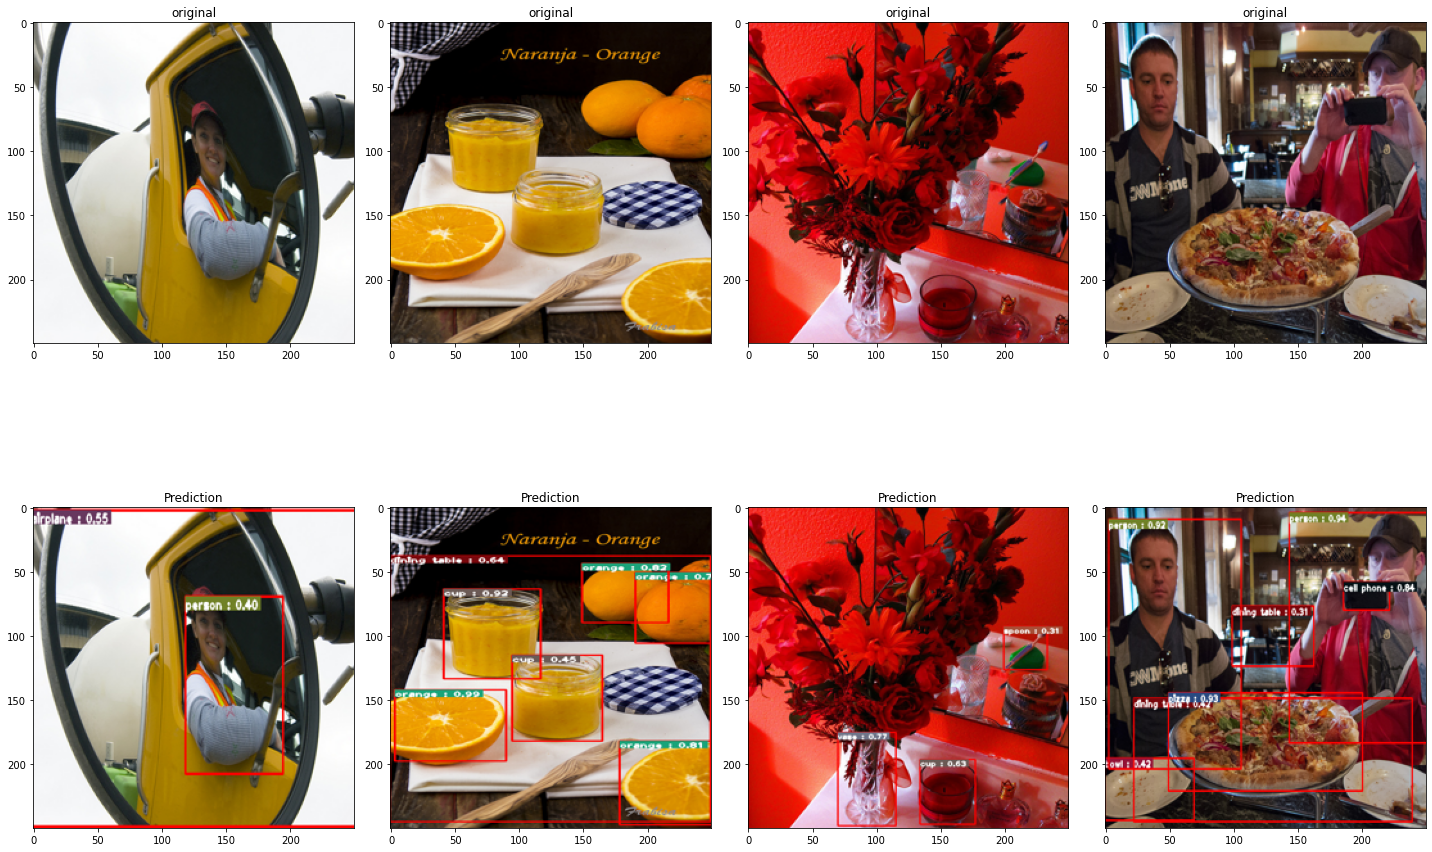

In [ ]:

# if os.path.exists(result_dir) is False:
#   os.makedirs(result_dir, exist_ok=True)
plt.figure(figsize=(20,20))
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
dir = os.listdir(dir_path) 
path_img=dir[0:4]
var=0
k=1
j=5
for i in path_img:

    model = SSD(backbone=ResNet())
    checkpoint = torch.load(ckpt, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["model_state_dict"])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
      model.cuda()
    else:
      model.to(device)
    model.eval()
    dboxes = generate_dboxes()
    transformer = SSDTransformer(dboxes, (300, 300), val=True)
    print(dir_path, i)
    img = Image.open(dir_path+'/'+i).convert("RGB")
    img, _, _, _ = transformer(img, None, torch.zeros(1,4), torch.zeros(1))
    encoder = Encoder(dboxes)


    if torch.cuda.is_available():
      img = img.cuda()
    else:
      img=img.to(device)

    with torch.no_grad():
      ploc, plabel = model(img.unsqueeze(dim=0))
      result = encoder.decode_batch(ploc, plabel, nms_threshold, 20)[0]
      loc, label, prob = [r.cpu().numpy() for r in result]
      best = np.argwhere(prob > cls_threshold).squeeze(axis=1)
      loc = loc[best]
      label = label[best]
      prob = prob[best]
      output_img = cv2.imread(dir_path+'/'+ i)
      if len(loc) > 0:
          height, width, _ = output_img.shape
          loc[:, 0::2] *= width
          loc[:, 1::2] *= height
          loc = loc.astype(np.int32)
          for box, lb, pr in zip(loc, label, prob):
              category = coco_classes[lb]
              color = colors[lb]
              xmin, ymin, xmax, ymax = box
              cv2.rectangle(output_img, (xmin, ymin), (xmax, ymax), (0,0,255), 2)
              text_size = cv2.getTextSize(category + " : %.2f" % pr, cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
              cv2.rectangle(output_img, (xmin, ymin), (xmin + text_size[0] + 3, ymin + text_size[1] + 4), color,
                            -1)
              cv2.putText(
                  output_img, category + " : %.2f" % pr,
                  (xmin, ymin + text_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1,
                  (255, 255, 255), 2)
              
      #cv2.imwrite(result_dir+'/'+i[:-4]+'.jpg', output_img)      
      img = Image.open(dir_path+'/'+path_img[var])
      output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
      img_pred = Image.fromarray(output_img)
      img=img.resize((250,250))
      img_pred=img_pred.resize((250,250))
      plt.subplot(2,4,k)
      plt.imshow(img)
      plt.title('original')
      plt.subplot(2,4,j)
      plt.imshow(img_pred)
      plt.title('Prediction')
      k=k+1
      j=j+1
      var=var+1